In [1]:
import numpy as np
import scipy as sp
# from pydmd import DMD
# from pydmd.plotter import plot_summary
# from pydmd.preprocessing import hankel_preprocessing

import matplotlib.pyplot as plt
import tristanVis.isolde as isolde
from tqdm import tqdm
# out_dir = "../slurm_scripts/output/"
out_dir = "/scratch/10446/anindya_12/tristan_mp_v2/slurm_scripts/output"
# out_dir = "../vault/output_psi0.5_mul1_3_mul2_0.1_src/"
run_no = "18"
"""
Typical stuff read from the input file
"""
# "../slurm_scripts/" + "temp_input_psi0.5_mul10.in"
# input_file_name = out_dir + "temp_input_psi0.5_mul13_mul20.1.in"  #"../inputs/inputAG.2d_EM_wave_emb_2"
input_file_name = "/scratch/10446/anindya_12/tristan_mp_v2/slurm_scripts/temp_input_psi0.5_mul13_mul20.1_TT1.9e-2.in"
# input_file_name = "../slurm_scripts/" + "temp_input_psi0.5_mul13_mul20.1.in"
# input_file_name = "../slurm_scripts/inputAG.2dtwostream_thermal_Bfield_0"
# hist            = isolde.parseHistory(out_dir + "history")
input_params    = isolde.parseInput(input_file_name)
m1              = input_params["particles"]["m1"]
m2              = input_params["particles"]["m2"]
interval        = input_params["output"]["interval"]
lst_time        = input_params["time"]["last"]
grid_x          = int(input_params["grid"]["mx0"])
grid_y          = int(input_params["grid"]["my0"])
Nsteps          = int(lst_time// interval)
CC              = input_params["algorithm"]["c"]
COMP            = input_params["plasma"]["c_omp"]
ppc0            = input_params["plasma"]["ppc0"]
SIGMA           = input_params["plasma"]["sigma"]
B_norm          = CC**2 * SIGMA**0.5 / COMP
unit_ch         = CC**2 / (ppc0 * COMP**2)
# weight_fac      = 2.405980
# omegap0         = CC / COMP * np.sqrt(weight_fac)
# time            = hist["time"] * omegap0
B_0             = input_params["problem"]["B_0"]#["B_0""B_field"]
B_amp           = input_params["problem"]["B_amplitude"]
duration        = input_params["problem"]["duration"]
freq            = input_params["problem"]["frequency"]
# spread          = input_params["problem"]["spread"]
# mode            = input_params["problem"]["mode"]
psi             = input_params["problem"]["psi"]
mult1           = input_params["problem"]["multiplicity_1"]
mult2           = input_params["problem"]["multiplicity_2"]
wA_wp           = input_params["problem"]["wA_wp"]
ramp_width      = input_params["problem"]["ramp_width"]
wall_x_location = input_params["problem"]["wall_x"]

mode = 2 * np.pi * freq / (CC * np.cos(psi))
init_x_boundary = 5 * np.pi / mode + wall_x_location
fin_x_boundary = init_x_boundary + ramp_width * 2 * np.pi / mode

weight_fac = (mode * np.sin(psi) * B_norm/unit_ch) / (0.5 * ppc0)
ds = COMP / np.sqrt(weight)

omegap0         = CC / ds

#  Weight factor:   1.696659 (upcoming)

"""
A WORD FROM ANINDYA (2/6/2024) ABOUT UNITS !!
#############################################

In my experience with Tristan code units, its most convenient to use dimensionless units of time and space.
Set code time steps and space steps to 1 (like, mentally : you don't have to do anything).
dt = 1
dx = 1

Then omegap0 is the plasma frequency in this units = CC / COMP dt^-1 = CC/COMP
And Debye length / skin-depth, d_e = COMP dx = COMP.

If (x,t) is (space,time) in code units then use the dimensionless (x/d_e, omegap0 * t) for all physics expressions/ theory.

BTW, in these units defined as such speed of light is c = CC dx/dt = CC.
"""

def fetch_var_at_step(out_dir, var, step):
    """
    This wrapper function fetches either particle or field data at any output step (!NOT! simulation time step) 
    from an output directory. Obviously.
    """
    filename = out_dir + var + '/' + var + '.tot.%05i'%step
    if var == "prtl":
        return(isolde.getParticles(filename))
    elif var == "flds":
        return(isolde.getFields(filename))
    else:
        print("Not supported yet!")
        return False

"""
TEMPLATES to fetch density, electric field and particle positions / velocities
##############################################################################

# density = np.zeros(shape = (2, Nsteps,grid_x))
# for step in range(Nsteps):
#     density[0, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens1"][0,0,:]
#     density[1, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens2"][0,0,:]

# Ex = np.zeros(shape = (Nsteps,grid_x))
# for step in range(Nsteps):
#     Ex[step,:] = fetch_var_at_step(out_dir, "flds", step)["ex"][0,0,:]

"""
# density1 = np.zeros(shape = (Nsteps, grid_y, grid_x))
# density2 = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Ex = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Ey = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Bx = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Bz = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Jx = np.zeros(shape = (Nsteps, grid_y, grid_x))
# Jy = np.zeros(shape = (Nsteps, grid_y, grid_x))

# X1 = []
# ux_1 = []
# Y1 = []
# uy_1 = []
# X2 = []
# ux_2 = []
# Y2 = []
# uy_2 = []


# for step in tqdm(range(Nsteps)):
#     # density1[step,:,:] = np.average(fetch_var_at_step(out_dir, "flds", step)["dens1"][:,:,:], axis = 0)
#     # density2[step,:,:] = np.average(fetch_var_at_step(out_dir, "flds", step)["dens2"][:,:,:], axis = 0)
    # X1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['x'])
    # ux_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['u'])
    # Y1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['y'])
    # uy_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['v'])

    # X2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['x'])
    # ux_2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['u'])
    # Y2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['y'])
    # uy_2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['v'])
    
    # Jx[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["jx"][:,:,:], axis = 0)
    # Ex[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["ex"][:,:,:], axis = 0)
    # Jy[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["jy"][:,:,:], axis = 0)
    # Ey[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["ey"][:,:,:], axis = 0)
    #Ey[step,:,:]       = fetch_var_at_step(out_dir, "flds", step)["ey"][0,:,:]
    #Bx[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["bx"][:,:,:], axis = 0)
    # Bz[step,:,:]       = np.average(fetch_var_at_step(out_dir, "flds", step)["bz"][:,:,:], axis = 0)
# X1=np.array(X1)
# ux_1 = np.array(ux_1)
# Y1=np.array(Y1)
# uy_2 = np.array(uy_2)

# data = isolde.parseUsrOutput(out_dir +'usroutput')[400]['eparr_av']

# plt.plot(data[np.abs(data) <= 1e1 ])


KeyError: 'duration'

ValueError: The python kernel does not appear to be a conda environment.  Please use ``%pip install`` instead.

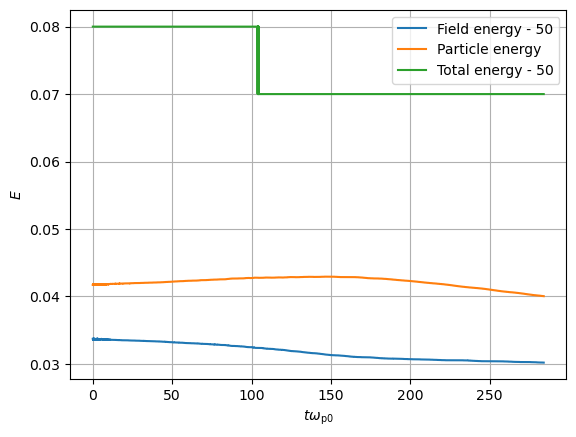

In [305]:
plt.plot(hist["time"] * omegap0, hist['Ex^2'] + hist['Ey^2'] + hist['Ez^2'] + hist['Bx^2'] + hist['By^2'] + hist['Bz^2'] - 50,
        label = "Field energy - 50")
plt.plot(hist["time"] * omegap0, hist["Esp1"] + hist["Esp2"], label = "Particle energy")
plt.plot(hist["time"] * omegap0, hist["Etot"]-50, label = "Total energy - 50")
plt.legend()
plt.xlabel(r"$t\omega_{\rm p0}$") 
plt.ylabel(r"$E$")
plt.grid()

In [72]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

def bg_density_scaled(x):
    n_0_local = mult1
    if mult1 != mult2:        
        k = np.log((mult1-mult2) / (0.01 * mult2))/ (fin_x_boundary - init_x_boundary)
        if x < init_x_boundary:
            n_0_local = mult1
        else:
            n_0_local = mult1 + (mult2 - mult1) * (1.0 - (1.0 + k*(x - init_x_boundary)) * np.exp(-k*(x - init_x_boundary)))
        # n_0_local = mult1 * np.exp(- k * (x - init_x_boundary))
    # if (x <= init_x_boundary):
    #     n_0_local = mult1
    
    # elif (x > fin_x_boundary):
    #     n_0_local = mult2

    # else :
    #     t = (x - init_x_boundary)/(fin_x_boundary - init_x_boundary)        
    #     n_0_local = mult1 + (mult2 - mult1) * (3.0*t**2 - 2.0*t**3)
    return n_0_local


scale_x = lambda x: CC / omegap0 * np.sqrt(bg_density_scaled(0)/bg_density_scaled(x))
scale_x_inv = lambda x: 1/scale_x(x)
scale_y = CC / omegap0
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(sp.integrate.quad(scale_x_inv, 0, x)[0]))
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))

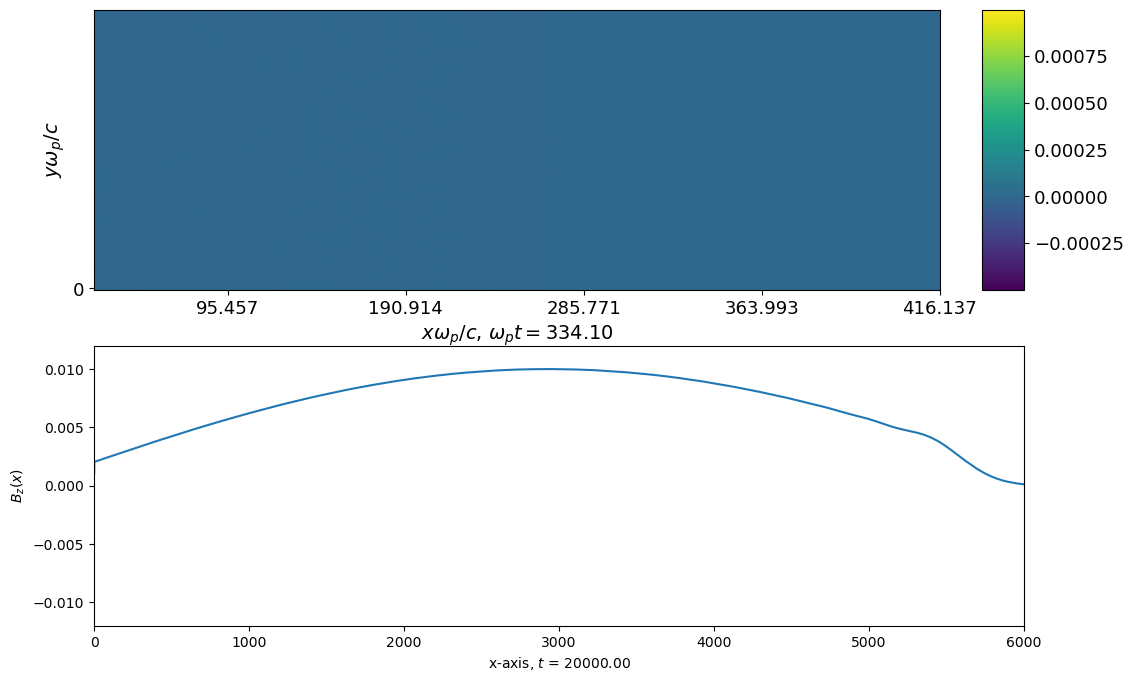

In [34]:
"""
ANIMATION: Make sure to "fetch" the appropriate data first.
###########################################################

This code here is optimised for animating a scalar field faster
"""

from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 12))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# fig, ax1 = plt.subplots(1, 1, figsize=(11, 4))
# fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]

# ax1.set_title(r"charge density $=|e^-| (n_{e^+}-n_{e^-})$")
# ax1.set_title(r"Density fluctuations $\delta n_e/ n_{e,0}$",fontsize=16)
# ax1.set_title(r"$j_{||}/B_0 (x,y) $ ")


div = make_axes_locatable(ax1)
cax = div.append_axes('right', '5%', '5%')

d1_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:], axis = 0)#/B_norm
d2_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens2"][:,:,:], axis = 0)#/B_norm

def arr_func(step):
    # d1 = np.average(fetch_var_at_step(out_dir, "flds", step)["dens1"][:,:,:], axis = 0)#/B_norm
    # d2 = np.average(fetch_var_at_step(out_dir, "flds", step)["dens2"][:,:,:], axis = 0)#/B_norm
    Ex = np.average(fetch_var_at_step(out_dir, "flds", step)["ex"][:,:,:], axis = 0)/B_norm
    Ey = np.average(fetch_var_at_step(out_dir, "flds", step)["ey"][:,:,:], axis = 0)/B_norm
    # e_fiducial = CC**2/(ppc0 * COMP**2)
    # # d_fluc = (d1 + d2 - d1_0 -  d2_0)/(d1_0 + d2_0)
    # rho_d = d1 #+ d2
    return  Ex * np.cos(psi) + Ey * np.sin(psi) 
    # return  rho_d #d_fluc[:, :] #jx * np.cos(psi) + jy * np.sin(psi) #density1[step, : , : ] - density2[step, : , : ]

im = ax1.imshow(arr_func(0)[:,:], origin='lower', aspect = 'auto') 
cb = fig.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=13)
tx = ax1.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
ax1.set_ylabel(r"$y \omega_{p}/ c$", fontsize = 14)

# Change only ax2
# scale_x = CC / omegap0
# scale_y = CC / omegap0
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax1.xaxis.set_major_formatter(ticks_x)

# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)

ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_xlim(500, 10000)
# ax1.annotate(r"$B_0$",
#             xytext=(1000, 0), xycoords='data',  # Head of the arrow
#             xy=(1000 + int(np.cos(psi) * 200), 0 + int(np.sin(psi) * 200)), textcoords='data',  # Tail of the arrow
#             arrowprops=dict(arrowstyle="->", lw=4),  # Arrow style and properties
#             fontsize = 15
#             )

# bz_max = np.max(Bz)/B_norm
# bz_min = np.min(Bz)/B_norm

track_pulse = False

# Function to update the frame
def animate_scalar(frame):
    arr = arr_func(frame)[:,:]
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    # tx.set_text(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))
    tx.set_text(r"$x \omega_{p}/ c$, $\omega_{p}t = $" + "{:.2f}".format(frame * interval * omegap0))
    
    ax2.clear()
    bz = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)[0,:]
    ax2.plot(xx, bz/(B_norm * B_0))     
    # ax2.set_xlabel(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))
    ax2.set_xlabel(r"x-axis, $t$ = " + "{:.2f}".format(frame * interval))
    ax2.set_ylabel(r"$B_z(x)$")
    ax2.set_ylim(-1.2*B_amp, 1.2*B_amp)
    
    # ax1.set_xlim(1000, 3000)#(0, grid_x)
    ax2.set_xlim(0,6000)#(0, grid_x)
    
    # if track_pulse:
    #     x_mid = grid_x * (0.5 - direct * 1/6) + direct * CC * frame * interval
    #     ax1.set_xlim(max(x_mid - 4 * spread, 0), min(x_mid + 4 * spread, grid_x))
    #     ax2.set_xlim(max(x_mid - 4 * spread, 0), min(x_mid + 4 * spread, grid_x))
    return ax2.get_children()
# Create the animation
# ani = FuncAnimation(fig, animate_scalar, frames=tqdm(range(Nsteps)), blit=False)

# # Save the animation
# writer = FFMpegWriter(fps=10, bitrate=2400)
# ani.save("./ch_dens(x,y)_PARAMS_B_amp_plasma_{}= {:.2f}, mode = {:.3f}, angle = {:.2f}.mp4".format(run_no, B_amp, mode, psi), 
#          writer=writer, dpi=800)
animate_scalar(frame = 100)

plt.show()


In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
fig, ax = plt.subplots(figsize=(8,2))

xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]

def animate_By(frame):
    ax.clear()
    # ax.scatter(0, -0.2)
    # ax.scatter(0, 0.2)
    bz = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)[0,:]
    # ax.plot(xx, Bz[frame, 0, :]/(B_norm * B_0)) 
    ax.plot(xx, bz/(B_norm * B_0)) 
    ax.set_ylim(-0.015, 0.015)
    ax.set_xlabel(r"x-axis $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))    
    ax.set_ylabel(r"$B_z(x)/B_0$")
    #ax.legend(loc="upper left")
    return ax.lines  # Return a list of Artists

# Create the animation
ani = FuncAnimation(fig, animate_By, frames=tqdm(range(Nsteps)), blit=False)

# Save the animation
writer = FFMpegWriter(fps=15, bitrate=1800)
ani.save("./Bz(x,t)_PARAMS_B_amp_plasma_test4= {:.2f}.mp4".format(B_amp), 
         writer=writer, dpi=400)

plt.show()

100%|██████████████████████████████████████████████████████████████████████| 250/250 [13:47<00:00,  3.31s/it]


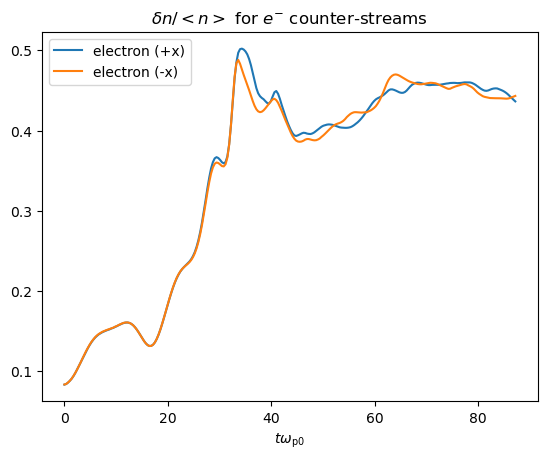

In [69]:
delta_d1 = np.array([np.std(fetch_var_at_step(out_dir, "flds", frame)["dens1"][0,:400,:5000]) for frame in tqdm(range(250))])
delta_d2 = np.array([np.std(fetch_var_at_step(out_dir, "flds", frame)["dens2"][0,:400,:5000]) for frame in tqdm(range(250))])

mean_d1  = np.mean(fetch_var_at_step(out_dir, "flds", 0)["dens1"][0,:,:])
mean_d2  = np.mean(fetch_var_at_step(out_dir, "flds", 0)["dens2"][0,:,:])

T =np.arange(delta_d1.shape[0]) * interval * omegap0
fig, ax = plt.subplots()
ax.plot(T, delta_d1/mean_d1, label = "electron (+x)")
ax.plot(T, delta_d2/mean_d2, label = "electron (-x)")
ax.set_title(r"$\delta n / <n>$ for $e^{-}$ counter-streams")
ax.set_xlabel(r"$t\omega_{\rm p0}$")
# ax.set_xlim(0, 24)
# ax.set_ylabel(r"$U_E / E_{\rm tot}$")
plt.legend()

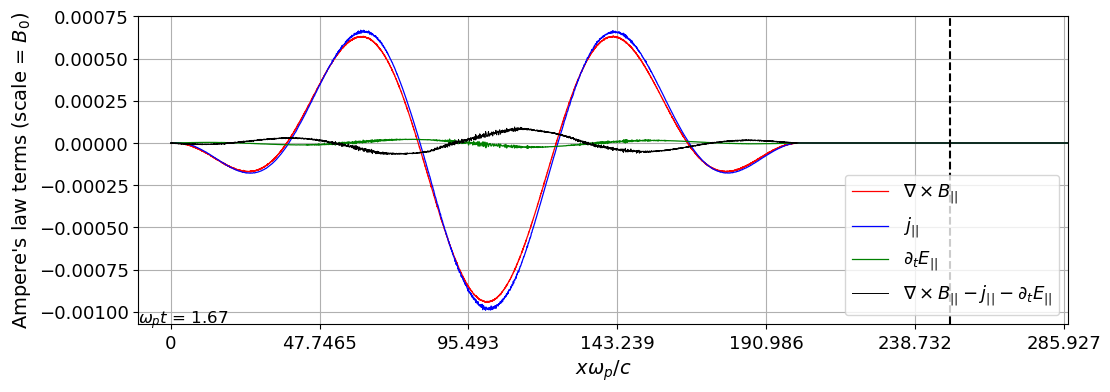

In [539]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]
ax1.tick_params(axis='both', which='major', labelsize=13)
# scale_x = CC / omegap0
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
# ax1.xaxis.set_major_formatter(ticks_x)

# n0_data = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:], axis = (0,1))
# scale_x = lambda x: CC / omegap0 * np.sqrt(n0_data[5]/n0_data[int(x)])
# integ_scalex = lambda x: 1/scale_x(x)
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(sp.integrate.quad(integ_scalex ,0, x)[0]))

# Function to update the frame
def animate_ampere(frame):
    ex_1         = np.average(fetch_var_at_step(out_dir, "flds", frame-1)["ex"][:,:,:], axis = 0)*B_norm
    ey_1         = np.average(fetch_var_at_step(out_dir, "flds", frame-1)["ey"][:,:,:], axis = 0)*B_norm
    ex_2         = np.average(fetch_var_at_step(out_dir, "flds", frame+1)["ex"][:,:,:], axis = 0)*B_norm
    ey_2         = np.average(fetch_var_at_step(out_dir, "flds", frame+1)["ey"][:,:,:], axis = 0)*B_norm
    del_t_ex     = (ex_2 - ex_1)/(2 * interval * omegap0)
    del_t_ey     = (ey_2 - ey_1)/(2 * interval * omegap0)
    
    jx           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,:], axis = 0) * B_norm /omegap0 * CC
    jy           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,:], axis = 0) * B_norm /omegap0 * CC
    
    bz           = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)*B_norm
    del_x_bz     = np.gradient(bz, axis = 1) / (omegap0/CC)
    del_y_bz     = np.gradient(bz, axis = 0) / (omegap0/CC)

    curl_b_parr  = np.average(del_y_bz * np.cos(psi) - del_x_bz * np.sin(psi), axis = 0)
    del_t_e_parr = np.average(del_t_ex * np.cos(psi) + del_t_ey * np.sin(psi), axis = 0)
    j_parr       = np.average(      jx * np.cos(psi) +       jy * np.sin(psi), axis = 0)
    
    ax1.clear()
    
    ax1.plot(xx, curl_b_parr*CC                         ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    # ax1.plot(xx, bz[0]                        ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    ax1.plot(xx, j_parr                                 ,color = "blue" , linewidth = 0.9, label = r"$j_{||}$")
    ax1.plot(xx, del_t_e_parr                           ,color = "green", linewidth = 0.9, label = r"$\partial_t E_{||}$")
    ax1.plot(xx, curl_b_parr*CC - j_parr - del_t_e_parr  ,color = "black", linewidth = 0.7, label = r"$\nabla \times B_{||} - j_{||} - \partial_t E_{||}$")
    ax1.legend() 

    ax1.xaxis.set_major_formatter(ticks_x)
    
    # ax1.set_xlim(grid_x - 40 , grid_x)
    # ax1.set_xlim(18000, 26000)
    ax1.set_xlim(frame * CC * interval * np.cos(psi) - 500, frame * CC * interval * np.cos(psi) + 12000) #grid_x/2
    # ax1.set_ylim(-2e-5, 2e-5)
    ax1.set_xlabel(r"$x \omega_{p}/ c$", fontsize = 14)
    ax1.set_ylabel(r"Ampere's law terms (scale = $B_0$)", fontsize = 14)
    ax1.text(0, 0, r"$\omega_{p}t$ = " + "{:.2f}".format(frame * interval * omegap0), fontsize=12, transform=ax1.transAxes)
    ax1.legend(loc="lower right", fontsize = 13)
    ax1.axvline(init_x_boundary, color='black', linestyle='--')
    ax1.axvline(fin_x_boundary, color='black', linestyle='--')
    ax1.grid()
    # # ax2.psd(del_t_e_parr[2500:6000], Fs = (omegap0/CC)**(-1))
    # ax2.clear()
    
    # ax2.plot(xx, curl_b_parr*CC                         ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    # ax2.plot(xx, j_parr                                 ,color = "blue" , linewidth = 0.9, label = r"$j_{||}$")
    # ax2.plot(xx, del_t_e_parr                           ,color = "green", linewidth = 0.9, label = r"$\partial_t E_{||}$")
    # ax2.plot(xx, curl_b_parr*CC - j_parr - del_t_e_parr ,color = "black", linewidth = 0.7, label = "Ampere's law validity")
    # ax2.legend()
    # # ax2.set_xlim(grid_x/3, 2 * grid_x/3)
    # ax2.xaxis.set_major_formatter(ticks_x)
    # ax2.set_xlim(grid_x/2, grid_x)
    # ax2.set_xlabel(r"$x \omega_{p}/ c$")
    # ax2.set_ylabel(r"Ampere's law terms (scale = $B_0$)")
    # ax2.text(0, 0, r"$t$ = " + "{:.2f}".format(frame * interval ), fontsize=10, transform=ax1.transAxes)
    # ax2.legend(loc="lower right")

    # ax3.clear()
    
    # ax3.plot(xx, curl_b_parr*CC                         ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    # ax3.plot(xx, j_parr                                 ,color = "blue" , linewidth = 0.9, label = r"$j_{||}$")
    # ax3.plot(xx, del_t_e_parr                           ,color = "green", linewidth = 0.9, label = r"$\partial_t E_{||}$")
    # ax3.plot(xx, curl_b_parr*CC - j_parr - del_t_e_parr ,color = "black", linewidth = 0.7, label = "Ampere's law validity")
    # ax3.legend()
    # ax3.set_xlim( 2 * grid_x/3, grid_x)
    # ax3.set_xlabel(r"$x-axis$")
    # ax3.set_ylabel(r"Ampere's law terms (scale = $B_0$)")
    # ax3.text(0, 0, r"$t$ = " + "{:.2f}".format(frame * interval ), fontsize=10, transform=ax1.transAxes)
    # ax3.legend(loc="lower right")
    # return ax1.get_children() + ax2.get_children() + ax3.get_children()  # Return a list of Artists

# # # Create the animation
# ani = FuncAnimation(fig, animate_ampere, frames=tqdm(range(1, 890)), blit=False)

# # # Save the animation
# writer = FFMpegWriter(fps=10, bitrate=2400)
# ani.save("Ampere(x)_B_amp = {:.2f}, dens1 = {:.1f}, dens2 = {:.1f}, angle = {:.2f}.mp4".format(B_amp, mult1, mult2, psi), 
#          writer=writer, dpi=400)

animate_ampere(1)
plt.show()

In [391]:
"""
Radiation post-processing from currents
"""



import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit 
# Constants
mu_0 = 1  # Permeability of free space
# c = 1  # Speed of light

# Function to compute retarded time
@jit
def retarded_time(x, x_prime, t):
    return t - np.linalg.norm(x - x_prime) / CC

# Function to perform linear interpolation for current density
@jit
def interpolate_current_density(j_data, t_r, t_data):
    # Find the two closest time points around t_r
    n = np.searchsorted(t_data, t_r)
    if n < len(t_data) and n > 0:
        j_tn = j_data[n-1]  # Current density at time t_n
        j_tn1 = j_data[n]    # Current density at time t_{n+1}
        # Linear interpolation across time
        j_t_r = j_tn + (t_r - t_data[n-1]) / (t_data[n] - t_data[n-1]) * (j_tn1 - j_tn)
        return j_t_r
    else:
        raise ValueError("Retarded time is outside the range of available time steps")

# Function to compute vector potential
@jit
def vector_potential(x, J_data, x_prime, jacob, t, t_data, grid_shape):
    A = np.zeros(3)  # Vector potential has 3 components (in 3D)
    # Reshape J_data to access spatial points easily
    # print(J_data.shape)
    J_data_reshaped = J_data.reshape(len(t_data), -1, 3)  # Shape: (Nt, N, 3)

    # Compute vector potential by summing contributions from all sources
    for i, x_p in enumerate(x_prime):
        t_r = retarded_time(x, x_p, t)  # Get the retarded time
        J_xp_t = J_data_reshaped[:, i, :]  # Time series for one point
        J_xp_tr = interpolate_current_density(J_xp_t, t_r, t_data)  # Interpolated current density
        distance = np.linalg.norm(x - x_p)
        if distance > 0:  # Avoid division by zero
            A += (mu_0 / (4 * np.pi)) * J_xp_tr / distance * jacob
    return A

# Function to compute electric field
def electric_field(A_t, A_t_plus_dt, dt):
    return -(A_t_plus_dt - A_t) / dt  # E = -dA/dt

# Function to compute luminosity
def luminosity(E):
    return np.sum(E**2)  # L ∝ |E|²



649.5789426803395 781.1184471999637
847.9635232985597 916.2907963137377


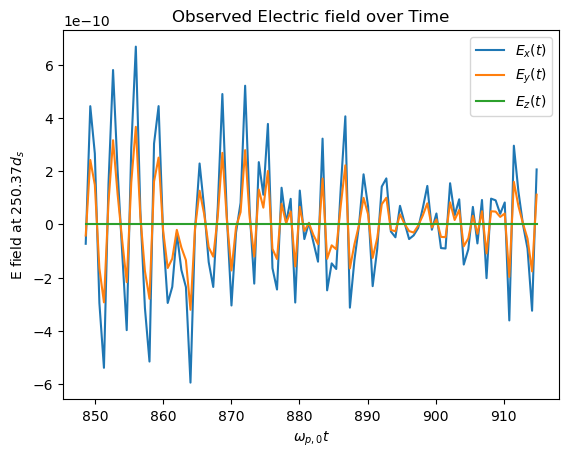

In [401]:
# 2D Simulation Parameters
frame_0 = 100
frame_f = 400

frame_data = np.arange(frame_0, frame_f)  # frames array
t_data = frame_data * interval * omegap0
dt = t_data[1] - t_data[0]

x_obs = np.array([frame_f * CC * interval * np.cos(psi) + 10000, grid_y//2]) * omegap0/CC # Observation point (in x-y plane, z is kept 0)

# Create a 2D grid of source points in the x-y plane
# grid_size = 100  # Number of grid points per axis
x_vals = np.arange(int(frame_0 * CC * interval * np.cos(psi)) - 200, int((frame_0 + 2) * CC * interval * np.cos(psi)) + 4500) * omegap0/CC
y_vals = np.arange(grid_y) * omegap0/CC

dx = (x_vals[-1] - x_vals[0])/x_vals.shape[0]
dy = (y_vals[-1] - y_vals[0])/y_vals.shape[0]

jacob = dx * dy
# Create a structured 2D grid (Nx, Ny)
X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

# # Define vector current density function J(x, y, t) with three components (Jx, Jy, Jz)
def J(frame):
    jx           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,int(frame_0 * CC * interval * np.cos(psi)) - 200 : int(frame_f * CC * interval * np.cos(psi)) + 4500], axis = 0)/B_norm 
    jy           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,int(frame_0 * CC * interval * np.cos(psi)) - 200 : int(frame_f * CC * interval * np.cos(psi)) + 4500], axis = 0)/B_norm  
    jz           = np.zeros_like(jx)
    return np.stack([jx, jy, jz], axis=-1)  # Stack components along last axis


# Compute J_data for all time steps (shape: (Nt, Nx, Ny, 3))
# J_data = np.array(Parallel(n_jobs=10)(delayed(J)(frame) for frame in tqdm(frame_data, desc = "Loading currents...")))


# J_data = np.array([J(frame) for frame in tqdm(frame_data, desc = "Loading currents...")])

# Flatten the 2D grid to pass as source points
x_prime_grid = np.vstack([X.ravel(), Y.ravel()]).T  # (N, 2)

# Precompute distances between the observation point and source points
distances = np.linalg.norm(x_obs[:2] - x_prime_grid, axis=1)  # Only x and y components

# Compute the min and max distances for retarded times
d_min = np.min(distances)
d_max = np.max(distances)

print(d_min/CC, d_max/CC)

t_min_obs = t_data[0] + d_max / CC  # Earliest observation time
t_max_obs = t_data[-1] + d_min / CC  # Latest observation time
obs_t_range = np.arange(t_min_obs + dt, t_max_obs - 2*dt, dt)

print(t_min_obs, t_max_obs)
# Parallel computation of luminosity using joblib
def compute_luminosity_for_time(t):
    A_t = vector_potential(x_obs, J_data, x_prime_grid, jacob, t, t_data, X.shape)
    A_t_plus_dt = vector_potential(x_obs, J_data, x_prime_grid, jacob, t + dt, t_data, X.shape)
    E = electric_field(A_t, A_t_plus_dt, dt)
    L = luminosity(E)
    return np.array(E)

# luminosity_values = [compute_luminosity_for_time(t) for t in obs_t_range]
E_values = np.array(Parallel(n_jobs=10)(delayed(compute_luminosity_for_time)(t) for t in obs_t_range))

# Plot the luminosity over time
# plt.plot(obs_t_range, luminosity_values)
plt.plot(obs_t_range, E_values[:, 0], label = r"$E_x (t)$")
plt.plot(obs_t_range, E_values[:, 1], label = r"$E_y (t)$")
plt.plot(obs_t_range, E_values[:, 2], label = r"$E_z (t)$")
plt.xlabel(r'$\omega_{p,0} t$')
# plt.ylabel('Luminosity')
plt.ylabel('E field at {:.2f}'.format((d_min + d_max) /2) + r'$d_s$')
# plt.title('Radiated Luminosity Over Time')
plt.title('Observed Electric field over Time')
plt.legend()
plt.show()



In [ ]:
"""
ANIMATION: Make sure to "fetch" the appropriate data first.
###########################################################

This code here is optimised for animating a scalar field faster
"""

from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]

#ax.set_title(r"Charge density $=|e^-| (n_{e^+}-n_{e^-})$")
ax1.set_title(r"$E_{||} (x,y) $ ")
div = make_axes_locatable(ax1)
cax = div.append_axes('right', '5%', '5%')

def arr_func(step):
    return Ex[step,:,:]*np.cos(psi) + Ey[step,:,:]*np.sin(psi)#density1[step, : , : ] - density2[step, : , : ]

im = ax1.imshow(arr_func(0), origin='lower', aspect = 'auto') 
cb = fig.colorbar(im, cax=cax)
tx = ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")


# Function to update the frame
def animate_scalar(frame):
    arr = arr_func(frame)
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    tx.set_text(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi)) 

    ax2.clear()
    ax2.plot(xx, Bz[frame, 0, :])   
    ax2.set_ylim(0, 0.3)
    ax2.set_xlabel(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))    
    ax2.set_ylabel(r"$B_z(x)$")
    return ax2.get_children()
# Create the animation
ani = FuncAnimation(fig, animate_scalar, frames=tqdm(range(Nsteps)), blit=False)

# Save the animation
writer = FFMpegWriter(fps=15, bitrate=2400)
ani.save("../vault_out/Wave_embed/E_par(x,y)_PARAMS_B_amp_plasma_19 = {:.2f}, freq = {:.2f}, duration = {:.1f}, angle = {:.2f}.mp4".format(B_amp, freq, duration, psi), 
         writer=writer, dpi=400)

plt.show()


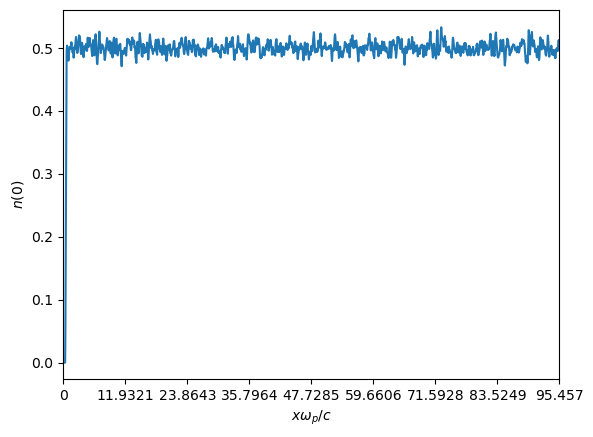

In [26]:
step = 000
diff = 0
dat = np.average(fetch_var_at_step(out_dir, "flds", step)["dens1"][:,:,:], axis = 0)
dat0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:], axis = 0)
dat = np.average(dat - diff * dat0, axis = 0)/(ppc0 * weight_fac)
fig, ax1 = plt.subplots()
ax1.set_xlabel(r"$x \omega_{p}/ c$")
ax1.xaxis.set_major_formatter(ticks_x)
# ax1.set_ylabel("$n({}) - n(0)$".format(step))
ax1.set_ylabel(r"$n({})$".format(step))
ax1.set_xlim(0, 2000)
ax1.plot(dat[:])
# ax1.axvline(fin_x_boundary)
# plt.plot(np.average(dat, axis = 0)/ppc0)
# print(np.max(dat))
# print(grid_x)

 99%|████████████████████████████████████████████████████████████▋| 179/180 [26:47<00:07,  7.27s/it]

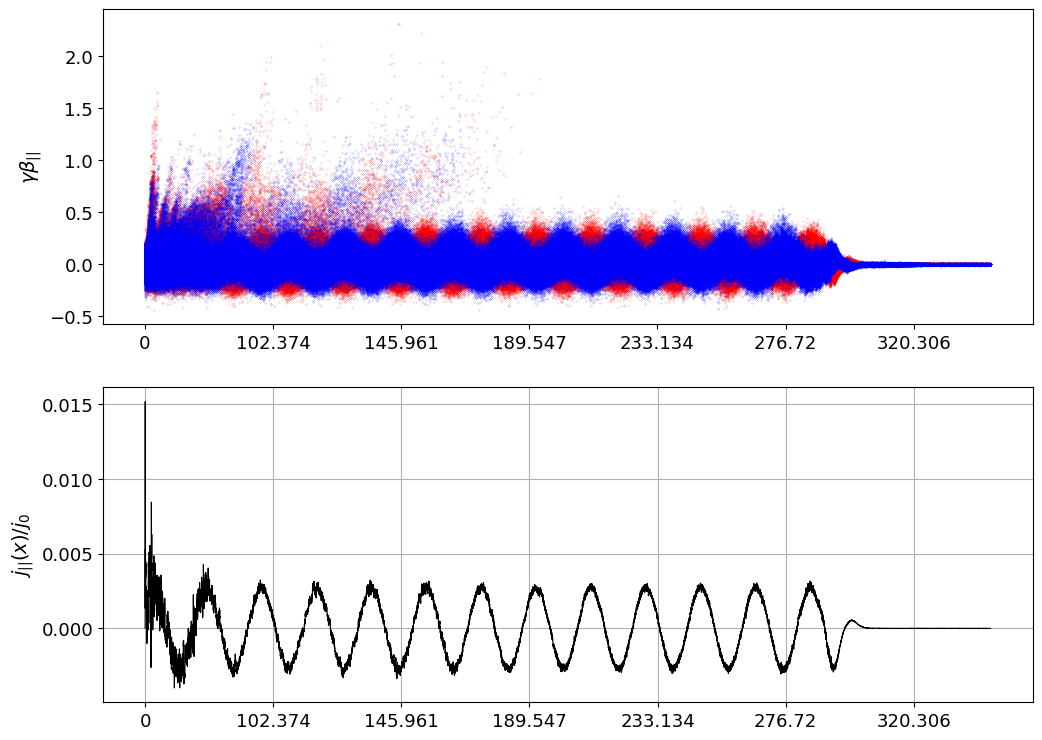

In [78]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
# fig, ax2= plt.subplots(1, 1, figsize=(12, 6))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]
# scale_x = CC / omegap0
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
# ax3.tick_params(axis='both', which='major', labelsize=13)
# Function to update the frame
def animate_particle(frame):
    ax1.clear()
    x1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['x']
    ux_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['u']
    # y1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['y']
    uy_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['v']

    x2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['x']
    ux_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['u']
    # y2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['y']
    uy_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['v']

    # random_indices1 = np.random.choice(len(x1), size=len(x1)//2, replace=False)
    # random_indices2 = np.random.choice(len(x2), size=len(x2)//2, replace=False)
    # ax1.scatter(x1[random_indices1], ux_1[random_indices1] * np.cos(psi) + uy_1[random_indices1] * np.sin(psi), s = 0.03, color = "red", label="positrons")
    # ax1.scatter(x2[random_indices2], ux_2[random_indices2] * np.cos(psi) + uy_2[random_indices2] * np.sin(psi), s = 0.01, color = "blue", label="electrons")
    
    ax1.scatter(x1[:], ux_1[:] * np.cos(psi) + uy_1[:] * np.sin(psi), s = 0.01, color = "red", label=r"$e^{+}$")
    ax1.scatter(x2[:], ux_2[:] * np.cos(psi) + uy_2[:] * np.sin(psi), s = 0.01, color = "blue", label=r"$e^{-}$")
    # ax1.set_ylim(-0.2, 0.2)
    # ax1.set_xlim(frame * CC * interval * np.cos(psi) - 500, frame * CC * interval * np.cos(psi) + 10000)
    # ax1.axvline(init_x_boundary, color='black', linestyle='--')
    # ax1.axvline(fin_x_boundary, color='black', linestyle='--')
    ax1.xaxis.set_major_formatter(ticks_x)
    # ax1.set_xlabel(r"$x \omega_{p}/ c$")
    ax1.set_ylabel(r"$\gamma \beta_{||}$", fontsize = 14)
    # ax1.text(0, 0, r"$t$ = " + r"{:.2f} $\omega_p$".format(frame * interval * omegap0), fontsize=10, transform=ax1.transAxes)
    # ax1.legend(loc="lower right", fontsize = 14)

    ax2.clear()
    # bz = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)[0,:]
    # ax2.plot(xx, bz/(B_norm * B_0))   
    
    # n_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:]) 
    # n_e = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = 0)[0,:]
    # ax2.plot(xx, n_e)
    # n_p = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis = 0)[0,:]
    # ax2.plot(xx, n_p)
    j_x = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,:], axis = (0, 1))[:]
    j_y = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,:], axis = (0, 1))[:]
    j_parr = (j_x * np.cos(psi) + j_y * np.sin(psi)) / (ppc0 * weight_fac * unit_ch)
    ax2.plot(xx, j_parr, linewidth = 0.8, color = "black")
    # ax2.plot(xx, n_p/n_0 - n_e/n_0)
    # ax2.set_ylim(-1.2*B_amp, 1.2*B_amp)
    # ax2.set_ylim(-0.3, 0.3)
    # ax2.axvline(init_x_boundary, color='black', linestyle='--')
    # ax2.axvline(fin_x_boundary, color='black', linestyle='--')
    # ax2.set_xlim(frame * CC * interval * np.cos(psi) - 500, frame * CC * interval * np.cos(psi) + 10000)
    ax2.xaxis.set_major_formatter(ticks_x)
    # ax2.set_xlabel(r"$x \omega_{p}/ c$, $t$ = " + "{:.2f}".format(frame * interval * omegap0))    
    # ax2.set_ylabel(r"$B_z(x)$", fontsize = 14)
    ax2.set_ylabel(r"$j_{||}(x)/j_0$", fontsize = 14)
    ax2.grid()

    # ax3.clear()
    # # n_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:]) 
    # n_e = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = (0, 1))[:]/(ppc0 * weight_fac)
    # ax3.plot(xx, n_e, color = 'blue', linewidth = 0.7, label = r'$e^{-}$ density')
    # n_p = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens2"][:,:,:], axis = (0, 1))[:]/(ppc0 * weight_fac)
    # ax3.plot(xx, n_p, color = 'red', linewidth = 0.7, label = r'$e^{+}$ density')

    # ax3.set_ylim(0, 2.5)
    # ax3.axvline(init_x_boundary, color='black', linestyle='--')
    # ax3.axvline(fin_x_boundary, color='black', linestyle='--')
    # # ax3.set_xlim(frame * CC * interval * np.cos(psi) - 500, frame * CC * interval * np.cos(psi) + 10000)
    # ax3.xaxis.set_major_formatter(ticks_x)
    # ax3.set_xlabel(r"$x \omega_{p}/ c$, $t$ = " + "{:.2f}".format(frame * interval * omegap0) + r"$\omega_{p}$", fontsize = 14)    
    # ax3.set_ylabel(r"$n(x)/n_0$", fontsize = 14)
    # ax3.legend(loc="upper right", fontsize = 14)
    # ax3.grid()
    # ax2.set_ylabel(r"$j_z/B_0$")
    
    return ax1.get_children() + ax2.get_children() + ax3.get_children() #ax1.lines + [ax1.texts[-1]]  # Return a list of Artists

# Create the animation
ani = FuncAnimation(fig, animate_particle, frames=tqdm(range(0, 900, 5)), blit=False)

# # Save the animation
writer = FFMpegWriter(fps=15, bitrate=8000)
ani.save("./phase_src_B_amp = {:.2f}, dens1 = {:.1f}, dens2 = {:.1f}, angle = {:.2f}.mp4".format(B_amp, mult1, mult2, psi), 
         writer=writer, dpi=400)
plt.show()
# animate_particle(frame = 900)
# plt.show()

In [509]:
print(weight_fac * ppc0)

0.028974371999999998


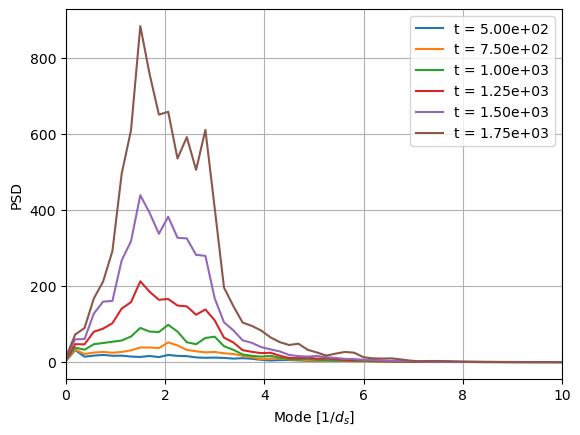

In [26]:
from scipy import signal

fs = ds #COMP / np.sqrt(weight_fac)  # Calculate sampling frequency

fig, ax = plt.subplots()

data = np.average(fetch_var_at_step(out_dir, "flds", 10)["dens1"][:,:,:], axis = 0)[0]
f, Pxx = signal.welch(data, fs)
ax.plot(f, Pxx, label = r"t = {:.2e}".format(10 * interval))

data = np.average(fetch_var_at_step(out_dir, "flds", 15)["dens1"][:,:,:], axis = 0)[0]
f, Pxx = signal.welch(data, fs)
ax.plot(f, Pxx, label = r"t = {:.2e}".format(15 * interval))

data = np.average(fetch_var_at_step(out_dir, "flds", 20)["dens1"][:,:,:], axis = 0)[0]
f, Pxx = signal.welch(data, fs)
ax.plot(f, Pxx, label = r"t = {:.2e}".format(20 * interval))

data = np.average(fetch_var_at_step(out_dir, "flds", 25)["dens1"][:,:,:], axis = 0)[0]
f, Pxx = signal.welch(data, fs)
ax.plot(f, Pxx, label = r"t = {:.2e}".format(25 * interval))

data = np.average(fetch_var_at_step(out_dir, "flds", 30)["dens1"][:,:,:], axis = 0)[0]
f, Pxx = signal.welch(data, fs)
ax.plot(f, Pxx, label = r"t = {:.2e}".format(30 * interval))

data = np.average(fetch_var_at_step(out_dir, "flds", 35)["dens1"][:,:,:], axis = 0)[0]
f, Pxx = signal.welch(data, fs)
ax.plot(f, Pxx, label = r"t = {:.2e}".format(35 * interval))

ax.set_xlabel(r'Mode [$1/d_s$]')
ax.set_xlim(0, 10)
ax.set_ylabel('PSD')
ax.grid()
ax.legend()
plt.show()

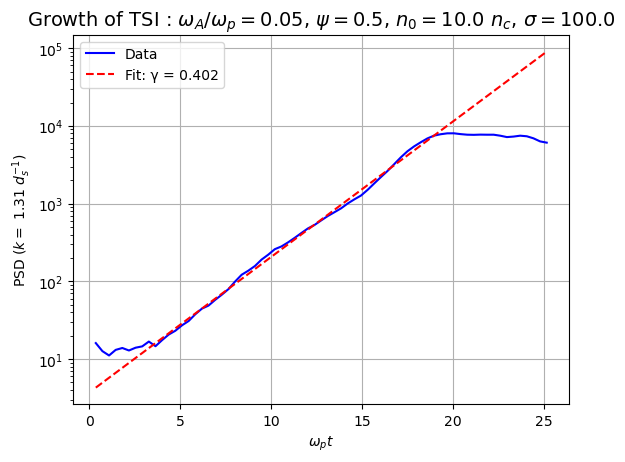

In [21]:
fs = ds #COMP/ np.sqrt(weight_fac)

data = np.average(fetch_var_at_step(out_dir, "flds", 30)["dens1"][:,:,:], axis = 0)[0]
f, Pxx = signal.welch(data, fs)

# To find the dominant peak (highest amplitude)
dominant_peak_idx = np.argmax(Pxx) - 1

# PSD_peak_val = []
# time_stamps = []
# for i in tqdm(range(1, 70)):
#     data = np.average(fetch_var_at_step(out_dir, "flds", i)["dens1"][:,:,:], axis = 0)[0]
#     f, Pxx = signal.welch(data, fs)
#     PSD_peak_val.append(Pxx[dominant_peak_idx])
#     time_stamps.append(i * interval * omegap0)

# fig, ax = plt.subplots()
# ax.plot(time_stamps, PSD_peak_val)
# ax.grid()
# ax.set_xlabel(r"$\omega_{p0} t$")
# ax.set_ylabel(r"PSD ($k =$ {:.2f}".format(f[dominant_peak_idx]) + r" $d_s^{-1}$)")


time_stamps = np.array(time_stamps)
PSD_peak_val = np.array(PSD_peak_val)

# Take log of PSD values for linear fit
log_PSD = np.log(PSD_peak_val)

# Fit a line to the log data
coeffs = np.polyfit(time_stamps[10:-20], log_PSD[10:-20], 1)
growth_rate = coeffs[0]  # This is your growth rate

# Generate fitted curve
fit_curve = np.exp(coeffs[1]) * np.exp(growth_rate * time_stamps)

# Your existing plotting code with added fit line
fig, ax = plt.subplots()
ax.plot(time_stamps, PSD_peak_val, 'b-', label='Data')
ax.plot(time_stamps[:], fit_curve[:], 'r--', label=f'Fit: γ = {growth_rate:.3f}')
ax.grid()
ax.set_xlabel(r"$\omega_{p} t$")
ax.set_ylabel(r"PSD ($k =$ {:.2f}".format(f[dominant_peak_idx]) + r" $d_s^{-1}$)")
ax.legend()
ax.set_title(r"Growth of TSI : $\omega_A / \omega_p = {0}$, $\psi = {1}$, $n_0 = {2}$ $n_c$, $\sigma = {3}$".format(wA_wp, psi, mult1, SIGMA),
            fontsize = 14)
# Optional: set y-axis to log scale to better see exponential behavior
ax.set_yscale('log')
plt.savefig(r"Growth of TSI : wA_wp = {0}$, psi = {1}, n_0 = {2}n_c, sigma = {3}.png".format(wA_wp, psi, mult1, SIGMA),dpi = 400)
plt.show()

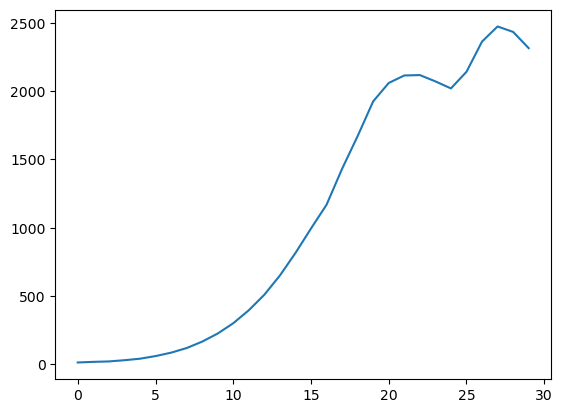

In [689]:
plt.plot(PSD_peak_val)

Text(0, 0.5, 'Max growth rate (${\\omega_p}^{-1}$)')

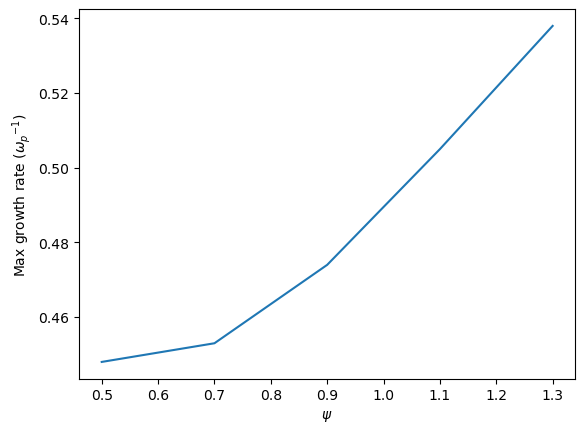

In [4]:
angles = [0.5, 0.7, 0.9, 1.1, 1.3]
grs_angles = [0.448, 0.453, 0.474, 0.505, 0.538]
plt.plot(angles, grs_angles)
plt.xlabel(r"$\psi$")
plt.ylabel(r"Max growth rate (${\omega_p}^{-1}$)")

<>:45: SyntaxWarning: invalid escape sequence '\D'
<>:45: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_17187/341465393.py:45: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel("$\Delta N$")


<function matplotlib.pyplot.show(close=None, block=None)>

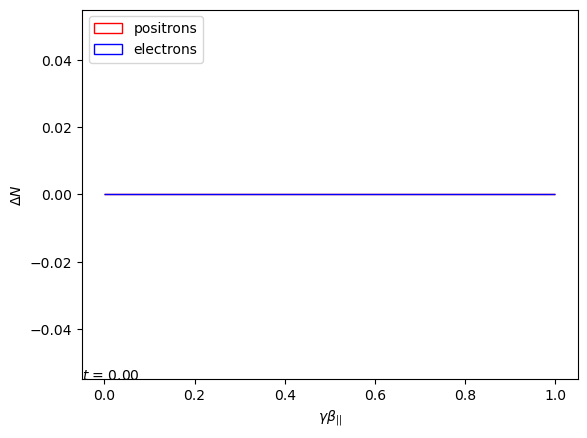

In [717]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
fig, ax = plt.subplots()


x_loc = 2400
delta_x = 20

# Function to update the frame
# def animate_phase(frame):
#     ax.clear()
#     # ax.scatter(0, -0.2)
#     # ax.scatter(0, 0.2)
#     ax.scatter(X1[frame, :], ux_1[frame, :], s = 0.01, color = "red", label="positrons")
#     ax.scatter(X2[frame, :], ux_2[frame, :], s = 0.01, color = "blue", label="electrons")    
#     ax.text(0, 0, "t=" + str(frame * interval), fontsize=10, transform=ax.transAxes)
#     ax.legend(loc="upper left")
#     return ax.lines + [ax.texts[-1]]  # Return a list of Artists
def animate_hist(frame):
    ax.clear()
    # ax.scatter(0, -0.2)
    # ax.scatter(0, 0.2)
    x1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['x']
    ux_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['u']
    # y1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['y']
    uy_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['v']

    x2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['x']
    ux_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['u']
    # y2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['y']
    uy_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['v']

    mask1 = (x1 > x_loc - delta_x/2) & (x1 < x_loc + delta_x/2)
    mask2 = (x2 > x_loc - delta_x/2) & (x2 < x_loc + delta_x/2)

    
    # ax.hist(ux_1[:] * np.cos(psi) + uy_1[:] * np.sin(psi), bins = 30, color = "red", label="positrons")
    # ax.hist(ux_2[:] * np.cos(psi) + uy_2[:] * np.sin(psi), bins = 30, color = "blue", label="electrons")
    ax.hist(ux_1[mask1] * np.cos(psi) + uy_1[mask1] * np.sin(psi), bins = 70, color = "red", 
            fill = False, histtype='step', label="positrons")
    ax.hist(ux_2[mask2] * np.cos(psi) + uy_2[mask2] * np.sin(psi), bins = 70, color = "blue", 
            fill = False, histtype='step', label="electrons")
    ax.text(0, 0, "$t$ = " + "{:.2f}".format(frame * interval), fontsize=10, transform=ax.transAxes)
    ax.set_xlabel(r"$\gamma \beta_{||}$")
    # ax.set_xlim(-0.5, 0.5)
    ax.set_ylabel("$\Delta N$")
    ax.legend(loc="upper left")
    return ax.lines + [ax.texts[-1]]  # Return a list of Artists

# # Create the animation
# ani = FuncAnimation(fig, animate_hist, frames=tqdm(range(Nsteps)), blit=False)

# # Save the animation
# writer = FFMpegWriter(fps=15, bitrate=1800)
# ani.save("/home/nuclear/tristan-v2/vault_out/Wave_embed/hist_PARAMS_B_amp_plasma_15 = {:.2f}, freq = {:.2f}, duration = {:.1f}, angle = {:.2f}.mp4".format(B_amp, freq, duration, psi), 
#          writer=writer, dpi=400)
animate_hist(0)
plt.show

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [08:55<00:00, 10.30s/it]


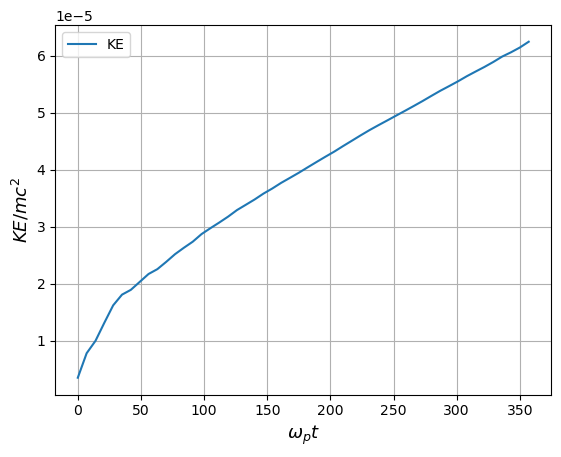

In [117]:
import numpy as np
from tqdm import tqdm
weight = 1.944037
# Precompute constants to avoid repeated calculations
# m1_CC2 = weight * m1 * CC**2
# m2_CC2 = weight * m2 * CC**2

w_m1 = weight * m1
w_m2 = weight * m2

x_loc = grid_x//2
delta_x = grid_x


def calc_KE(frame):
    # Fetch data for species 1 and species 2
    data_1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]
    data_2 = fetch_var_at_step(out_dir, "prtl", frame)["2"]

    x1, x2 = data_1["x"], data_2["x"]
    mask1 = (x1 > x_loc - delta_x/2) & (x1 < x_loc + delta_x/2)
    mask2 = (x2 > x_loc - delta_x/2) & (x2 < x_loc + delta_x/2)
    
    ux_1, uy_1 = data_1['u'][mask1], data_1['v'][mask1]
    ux_2, uy_2 = data_2['u'][mask2], data_2['v'][mask2]
    
    # # Calculate mod_u directly without creating intermediate arrays
    # mod_u_1 = np.sqrt(ux_1**2 + uy_1**2)
    # mod_u_2 = np.sqrt(ux_2**2 + uy_2**2)

    # # Calculate gamma and kinetic energy directly
    # gamma_1 = 1 / np.abs(np.cos(np.arctan(mod_u_1)))
    # gamma_2 = 1 / np.abs(np.cos(np.arctan(mod_u_2)))
    gamma_1 = np.sqrt(1 + ux_1**2 + uy_1**2)
    gamma_2 = np.sqrt(1 + ux_2**2 + uy_2**2)

    # plt.hist(gamma_1)

    # Calculate KE directly without creating intermediate arrays
    KE_1 = np.sum((gamma_1 - 1) * w_m1)#/ux_1.shape[0]
    KE_2 = np.sum((gamma_2 - 1) * w_m2)#/ux_2.shape[0]

    # bulk_gamma_1 = 1 / np.abs(np.cos(np.arctan(np.sqrt(np.average(ux_1)**2 + np.average(uy_1)**2))))
    # bulk_gamma_2 = 1 / np.abs(np.cos(np.arctan(np.sqrt(np.average(ux_2)**2 + np.average(uy_2)**2))))

    # bulk_gamma_1 = np.sqrt(1 + np.average(ux_1)**2 + np.average(uy_1)**2)
    # bulk_gamma_2 = np.sqrt(1 + np.average(ux_2)**2 + np.average(uy_2)**2)

    # bulk_KE_1 =  np.sum((bulk_gamma_1 - 1) * m1_CC2)# * ux_1.shape[0]
    # bulk_KE_2 =  np.sum((bulk_gamma_2 - 1) * m2_CC2)# * ux_2.shape[0]

    return (KE_1, KE_2)#, bulk_KE_1, bulk_KE_2)


# calc_KE(400)
# Optimize the computation over multiple frames
frames = np.arange(start = 0, stop = 520, step = 10)
KEs = np.array([calc_KE(frame) for frame in tqdm(frames)])
KEs = KEs/ppc0/(grid_x * grid_y)
KEs = KEs * CC**2
# Plot the result
plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1], label = "KE")
# plt.plot(frames * interval * omegap0, KEs[:,2] + KEs[:,3], label = "Bulk KE")
# plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1] - (KEs[:,2] + KEs[:,3]), label = "Thermal KE")
plt.xlabel(r"$\omega_{p}t$", fontsize = 13)
plt.ylabel(r"$KE/mc^2$", fontsize = 13)
plt.grid()
plt.legend()
plt.show()




In [770]:
print(B_norm)

0.024499999999999997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [02:31<00:00,  2.91s/it]


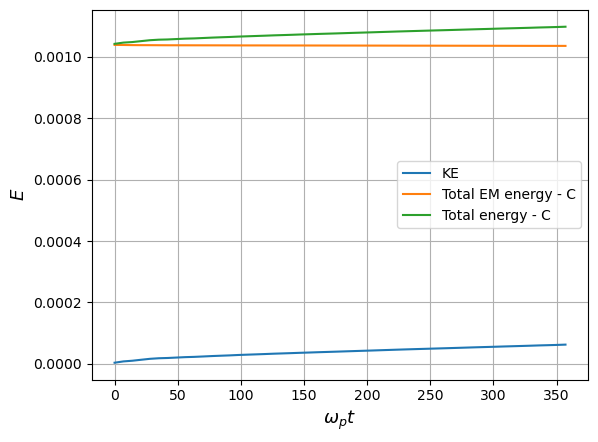

In [119]:
x_loc = grid_x//2
delta_x = grid_x
frames = np.arange(start = 0, stop = 520, step = 10)

def calc_FE(frame):
    data_1 = fetch_var_at_step(out_dir, "flds", frame)
    E_field_energy =  np.sum(data_1["ex"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2 + 
                             data_1["ey"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2 + 
                             data_1["ez"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2) * 0.5 * (1/CC**2 * COMP)**2
    # print(E_field_energy)
    Bw_field_energy =  np.sum((data_1["bx"][:,:,x_loc - delta_x//2:x_loc + delta_x//2] )**2 + 
                              (data_1["by"][:,:,x_loc - delta_x//2:x_loc + delta_x//2] )**2 + 
                              data_1["bz"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]**2) * 0.5 * (1/CC**2 * COMP)**2
    
    return (E_field_energy , Bw_field_energy)

FEs = np.array([calc_FE(frame) for frame in tqdm(frames)])/(grid_x * grid_y)

plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1], label = "KE")
plt.plot(frames * interval * omegap0, (FEs[:,0] + FEs[:,1]) * B_norm**2 - 0.029 , label = "Total EM energy - C")
plt.plot(frames * interval * omegap0, (KEs[:,0] + KEs[:,1]) + (FEs[:,0] + FEs[:,1])* B_norm**2 - 0.029 , label = "Total energy - C")
# plt.plot(frames * interval * omegap0, FEs[:,0] , label = "E field energy")
# plt.plot(frames * interval * omegap0, FEs[:,1] , label = r"$B_w$ field energy")
plt.xlabel(r"$\omega_{p}t$", fontsize = 13)
plt.ylabel(r"$E$", fontsize = 13)
plt.legend()
plt.grid()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [02:28<00:00,  2.18s/it]


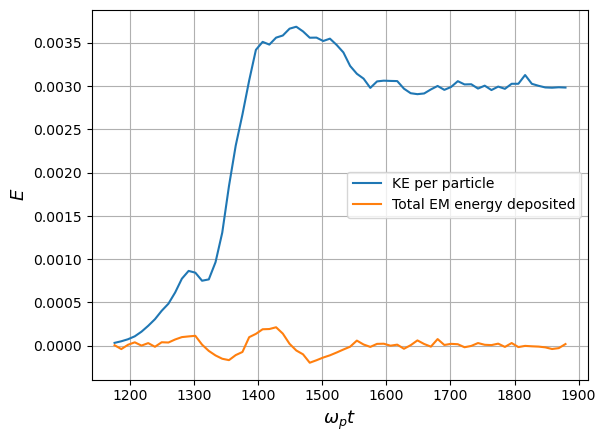

In [183]:
x_loc = 6000
delta_x = 25
frames = np.arange(start = 560, stop = 900, step = 5)

def calc_E_in_out(frame):
    data_1 = fetch_var_at_step(out_dir, "flds", frame)
    # ex = data_1["ex"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    ey = data_1["ey"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    ez = data_1["ez"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    
    # bx = data_1["bx"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    by = data_1["by"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]
    bz = data_1["bz"][:,:,x_loc - delta_x//2:x_loc + delta_x//2]

    # Cross product to get the Poynting vector components
    Sx = (ey * bz - ez * by)
    # Sy = (ez * bx - ex * bz)
    # Sz = (ex * by - ey * bx)

    #Incoming:
    incoming = np.sum(Sx[:, :, 0])
    outgoing = np.sum(Sx[:, :, -1])
    
    return (incoming , outgoing)
    

E_io_s = np.array([calc_E_in_out(frame) for frame in tqdm(frames)])
plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1], label = "KE per particle")
plt.plot(frames * interval * omegap0, E_io_s[:,0] - E_io_s[:,1] , label = "Total EM energy deposited")
# plt.plot(frames * interval * omegap0, FEs[:,0] , label = "E field energy")
# plt.plot(frames * interval * omegap0, FEs[:,1] , label = r"$B_w$ field energy")
plt.xlabel(r"$\omega_{p}t$", fontsize = 13)
plt.ylabel(r"$E$", fontsize = 13)
plt.legend()
plt.grid()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:23<00:00,  2.92it/s]


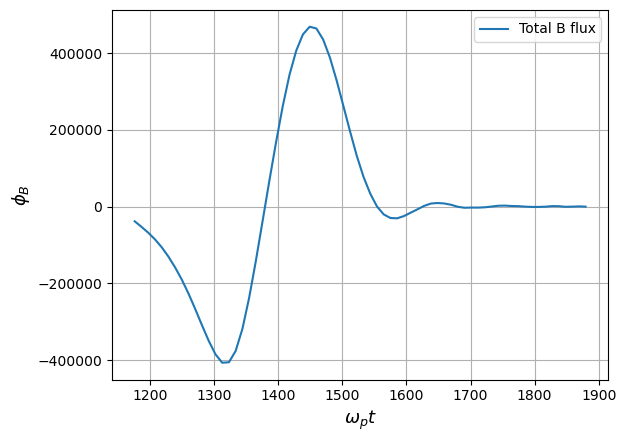

In [180]:
#div B check

x_loc = 6000
delta_x = 25
frames = np.arange(start = 560, stop = 900, step = 5)

def calc_Bflux(frame):
    data_1 = fetch_var_at_step(out_dir, "flds", frame)
    flux_x = 0*np.sum(data_1["bx"][:,:,x_loc + delta_x//2] * grid_y * 1 - data_1["bx"][:,:,x_loc - delta_x//2] * grid_y * 1)
    flux_y = 0*np.sum(data_1["by"][:, -1 ,x_loc - delta_x//2:x_loc + delta_x//2] * delta_x * 1 
                   - data_1["by"][:, 0 ,x_loc - delta_x//2:x_loc + delta_x//2] * delta_x * 1 )
    flux_z = np.sum(data_1["bz"][-1, : ,x_loc - delta_x//2:x_loc + delta_x//2] * delta_x * grid_y 
                    - 0 * data_1["bz"][0, : ,x_loc - delta_x//2:x_loc + delta_x//2] * delta_x * grid_y )
      
    return (flux_x + flux_y + flux_z)

Fluxs = np.array([calc_Bflux(frame) for frame in tqdm(frames)])

plt.plot(frames * interval * omegap0, Fluxs[:] , label = "Total B flux")
plt.xlabel(r"$\omega_{p}t$", fontsize = 13)
plt.ylabel(r"$\phi_{B}$", fontsize = 13)
plt.legend()
plt.grid()
plt.show()

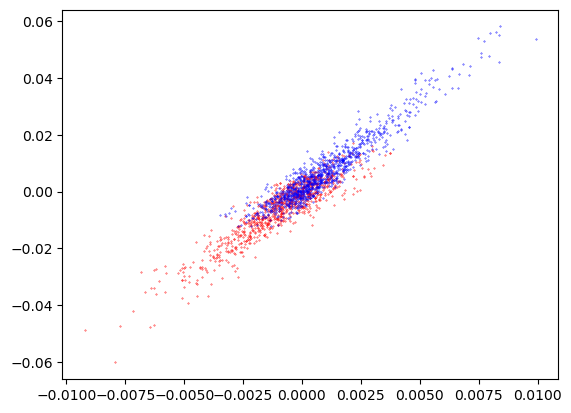

In [108]:
x_loc = 3000
delta_x = 10
frame = 190


data_1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]
data_2 = fetch_var_at_step(out_dir, "prtl", frame)["2"]

x1, x2 = data_1["x"], data_2["x"]
mask1 = (x1 > x_loc - delta_x/2) & (x1 < x_loc + delta_x/2)
mask2 = (x2 > x_loc - delta_x/2) & (x2 < x_loc + delta_x/2)
    
ux_1, uy_1 = data_1['u'][mask1], data_1['v'][mask1]
ux_2, uy_2 = data_2['u'][mask2], data_2['v'][mask2]

plt.figure()
plt.scatter(ux_1, uy_1, s=0.1, c = 'r')
# plt.figure()
plt.scatter(ux_2, uy_2, s=0.1, c = 'b')

In [319]:
t_series = [np.average(fetch_var_at_step(out_dir, "flds", frame)['ex'][0,:,4000]) for frame in tqdm(range(20, 100))]



100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [01:53<00:00,  1.42s/it]


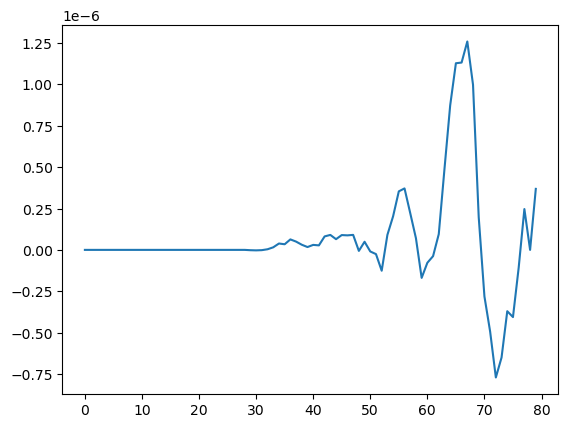

In [320]:
plt.plot(t_series)